# Actuator - LEDs

In this notebook we will learn how to use the LED component to change the LED pattern on a Duckiebot.

In [1]:
%load_ext autoreload
%autoreload 2

import os

# TODO: change this to the name of your Duckiebot
VEHICLE_NAME: str = "kizzy"

In [2]:
# Actuator - LEDs - Set color and intensity

import time

from duckietown.components.duckiebot import LEDsPattern, LEDsDriverComponent

# define component
leds: LEDsDriverComponent = LEDsDriverComponent(vehicle_name=VEHICLE_NAME)
leds.start()

# define new pattern
intensity: float = 0.3
pattern: LEDsPattern = LEDsPattern(
    front_left=(1, 0, 0, intensity),
    front_right=(0, 0, 0, intensity),
    rear_right=(0, 0, 0, 0),
    rear_left=(0, 0, 0, 1),
)

# set pattern
leds.in_pattern.put(pattern)

# let it sit for 5 seconds
try:
    time.sleep(5)
except KeyboardInterrupt:
    pass

# stop component
leds.stop()

Using ROS...
True
False


In [11]:
# Actuator - LEDs - Chameleon mode

import cv2
import numpy as np

from typing import Optional, Tuple
from functools import partial

from sklearn.cluster import KMeans
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv

from duckietown.types import BGRImage, BGR8Color, BGRColor, IQueue, Queue
from duckietown.components.base import Component
from duckietown.components.duckiebot import CameraDriverComponent, LEDsPattern, LEDsDriverComponent
from duckietown.components.rendering import ImageRendererComponent

OFF = (0, 0, 0, 0)

class MostDominantColorComponent(Component[BGRImage, BGRColor]):

    def __init__(self):
        super(MostDominantColorComponent, self).__init__()
        # queues
        self.in_bgr: IQueue = Queue()
        self.out_color: IQueue = Queue()

    def _crop(self, img: BGRImage) -> BGRImage:
        shape = img.shape
        w = int(shape[1]/2)
        h = int(shape[0]/2)
        x = shape[1]/2 - w/2
        y = shape[0]/2 - h/2
        return img[int(y):int(y+h), int(x):int(x+w)]

    def _most_dominant_color(self, img: BGRImage) -> BGRColor:
        # focus on 50% of the image around the center
        img = self._crop(img)
        pixels = img.reshape(-1, 3)
        # use k-means to cluster pixels
        kmeans = KMeans(n_clusters=1, n_init='auto')
        kmeans.fit(pixels)
        # most dominant color is the cluster center
        bgr: np.ndarray = kmeans.cluster_centers_[0]
        # in HSV, we can saturate S and V to enhance the color 
        bgr /= 255.
        rgb = bgr[::-1]
        hsv = rgb_to_hsv(rgb)
        hsv[1] = hsv[2] = 1.
        rgb = hsv_to_rgb(hsv)
        bgr = rgb[::-1]
        return bgr.tolist()
    
    def worker(self):
        while not self.is_shutdown:
            # get frame
            bgr: BGRImage = self.in_bgr.get()
            # find most dominant color
            color: BGRColor = self._most_dominant_color(bgr)
            # send color out
            self.out_color.put(color)


class ColorToPatternComponent(Component[BGRColor, LEDsPattern]):

    def __init__(self):
        super(ColorToPatternComponent, self).__init__()
        # queues
        self.in_color: IQueue = Queue()
        self.out_pattern: IQueue = Queue()
    
    def worker(self):
        while not self.is_shutdown:
            # get color
            color: BGRColor = self.in_color.get()
            b, g, r = color
            # prepare pattern
            pattern: LEDsPattern = LEDsPattern(
                # low intensity on the front to avoid affecting the color of the object in front of the camera
                front_left=(r, g, b, 0.05),
                front_right=(r, g, b, 0.05),
                rear_right=(r, g, b, 1.0),
                rear_left=(r, g, b, 1.0),
            )
            # send pattern out
            self.out_pattern.put(pattern)

# define component
leds: LEDsDriverComponent = LEDsDriverComponent(vehicle_name=VEHICLE_NAME)
camera: CameraDriverComponent = CameraDriverComponent(vehicle_name=VEHICLE_NAME, throttle_rate=100)
renderer: ImageRendererComponent = ImageRendererComponent()
image2color: MostDominantColorComponent = MostDominantColorComponent()
color2pattern: ColorToPatternComponent = ColorToPatternComponent()

# connect components
renderer.in_image.wants(camera.out_bgr)
image2color.in_bgr.wants(camera.out_bgr)
color2pattern.in_color.wants(image2color.out_color)
leds.in_pattern.wants(color2pattern.out_pattern)

# start components
leds.start()
camera.start()
renderer.start()
image2color.start()
color2pattern.start()

# wait until the cell is stopped
renderer.join()

# stop components
leds.stop()
camera.stop()
renderer.stop()
image2color.stop()
color2pattern.stop()

Using ROS...


TypeError: super(type, obj): obj must be an instance or subtype of type

Using ROS...
/kizzy/led_emitter_node/led_pattern
Using ROS...


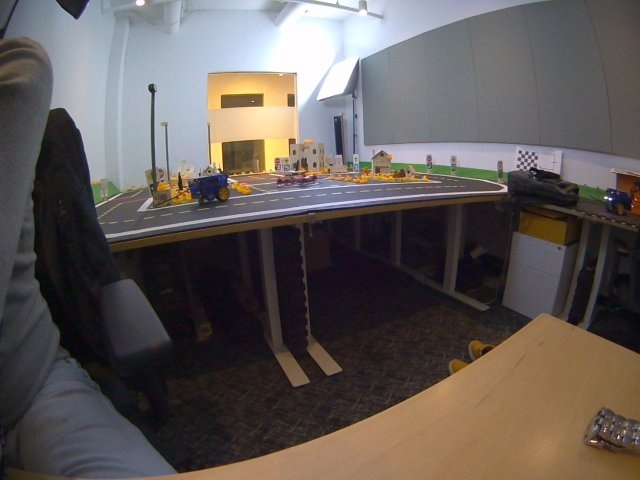

[system]: System booting...
[system]: Component LEDsDriverComponent@140410715499200 started!
[system]: Component CameraDriverComponent@140410686144864 started!
[system]: Component ImageRendererComponent@140410715499680 started!
[system]: Component MostDominantColorComponent@140410461641024 started!
[system]: Component ColorToPatternComponent@140410715498624 started!
[system]: System running...
[system]: Stopping component LEDsDriverComponent@140410715499200...
[system]: Stopping component CameraDriverComponent@140410686144864...
[system]: Stopping component ImageRendererComponent@140410715499680...
[system]: Stopping component MostDominantColorComponent@140410461641024...
[system]: Stopping component ColorToPatternComponent@140410715498624...
[system]: Waiting for component LEDsDriverComponent@140410715499200...
[system]: Component LEDsDriverComponent@140410715499200 finished
[system]: Waiting for component CameraDriverComponent@140410686144864...
[system]: Component CameraDriverCompon

In [5]:
# Actuator - LEDs - Chameleon mode - Using a System

from duckietown.system import System

# define component
leds: LEDsDriverComponent = LEDsDriverComponent(vehicle_name=VEHICLE_NAME)
camera: CameraDriverComponent = CameraDriverComponent(vehicle_name=VEHICLE_NAME, throttle_rate=100)
renderer: ImageRendererComponent = ImageRendererComponent()
image2color: MostDominantColorComponent = MostDominantColorComponent()
color2pattern: ColorToPatternComponent = ColorToPatternComponent()

# connect components
renderer.in_image.wants(camera.out_bgr)
image2color.in_bgr.wants(camera.out_bgr)
color2pattern.in_color.wants(image2color.out_color)
leds.in_pattern.wants(color2pattern.out_pattern)

# create system
system: System = System([leds, camera, renderer, image2color, color2pattern])

# run system (NOTE: this is blocking)
system.run()